# Predictive Analysis for Detecting Students at Risk of Severe COVID-19 Consecuences

This analysis 
This analysis employs the data mining and machine learning techniques given in class to 
identify the risk of COVID-19 complications in students.
The data comes from the provided hospital datasets that include information
on symptoms, comorbidities, and PCR test results.


### Business and Data Mining Goals

**Business Goal**: Create a safe examination environment by identifying students at risk for serious complications from COVID-19. This will allow academic and healthcare institutions to make preventive decisions.

**Business KPI**: Identification rate of high-risk students.

**Data Mining Goal**: Develop a classification model to segment students into risk levels (high, low and sick) so given the data set we will segment them into an age range so the focus will be on students from 15 to 18 years old, who correspond to the group in the final stage of high school facing critical exams, as indicated in the project plan (1st assigment: Project Plan).

**Data Mining KPI**: Accuracy and sensitivity in predicting high-risk students to apply preventive measures.

In [26]:
!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl catboost lightgbm xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 330.3 kB/s eta 0:06:19
   ---------------------------------------- 0.0/124.9 MB 330.3 kB/s eta 0:06:19
   ---------------------------------------- 0.2/124.9 MB 1.1 MB/s eta 0:01:59
   ---------------------------------------- 0.5/124.9 MB 2.4 MB/s eta 0:00:52
   ---------------------------------------- 1.0/124.9 MB 3.9 MB/s eta 0:00:32
   ---------------------------------------- 1.6/124.9 MB 5.2 MB/s eta 0:00:24
    --------------------------------------- 1.9/124.9 MB 5.5 MB/s eta 0:00:23
    --------------------------------------- 2.4/124.9 MB 6.0 MB/s eta 0:00:21
    --------------------------------------- 2.9/124.9 MB 6.3 MB/s eta 0:00:20
   - -------------------------------------- 3.5/124.9 MB 6.9 MB/s eta 0:00:18
   - -------------------------------------- 4.2/124.9 MB 7.6 MB/s eta 0:00

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
)
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

#### Loading the Data

In [2]:
file_path_hospital1 = './hospital1.xlsx'
file_path_hospital2 = './hospital2.xlsx'

hospital1_data = pd.read_excel(file_path_hospital1)
hospital2_data = pd.read_excel(file_path_hospital2)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True)
hospital1_data.head()

,patient ID,patient ID.1,nationality,age,gender K=female E=male,date_of_first_symptoms,BASVURUTARIHI,fever_temperature,oxygen_saturation,history_of_fever,cough,sore_throat,runny_nose,wheezing,shortness_of_breath,lower_chest_wall_indrawing,chest_pain,conjunctivitis,lymphadenopathy,headache,loss_of_smell,loss_of_taste,fatigue_malaise,anorexia,altered_consciousness_confusion,muscle_aches,joint_pain,inability_to_walk,abdominal_pain,diarrhoea,vomiting_nausea,skin_rash,bleeding,other_symptoms,chronic_cardiac_disease,hypertension,chronic_pulmonary_disease,asthma,chronic_kidney_disease,obesity,liver_disease,asplenia,chronic_neurological_disorder,malignant_neoplasm,chronic_hematologic_disease,AIDS_HIV,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,PCR_result
0,11850006,11850006,T.C.,47,K,2022-01-01,2022-01-01,38.2,96.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
1,4373630,4373630,T.C.,23,K,2022-01-01,2022-01-01,37.0,96.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
2,12172023,12172023,T.C.,26,K,2022-01-01,2022-01-01,38.0,95.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
3,72856168,72856168,T.C.,60,K,2022-01-01,2022-01-01,36.5,95.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
4,72200559,72200559,T.C.,72,K,2021-12-22,2021-12-22,36.9,96.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive


#### Data Preprocessing

In [4]:
# Filtro por rango de edad (15 a 70 años)
min_age, max_age = 15, 70

hospital1_data = hospital1_data[hospital1_data['age'].between(min_age, max_age)]
hospital2_data = hospital2_data[hospital2_data['age'].between(min_age, max_age)]

# Estandarización de nombres de columnas para facilitar la combinación
hospital1_data.columns = hospital1_data.columns.str.lower().str.replace(" ", "_")

# Eliminación de columnas duplicadas en hospital1_data
hospital1_data = hospital1_data.loc[:, ~hospital1_data.columns.duplicated()]
hospital1_data = hospital1_data.drop(columns=["patient_id.1"])

to_categorical_int = ['chronic_hematologic_disease', 'aids_hiv', 'diabetes_mellitus_type_1', 'diabetes_mellitus_type_2',
                  'rheumatologic_disorder', 'dementia']   # these were encoded as floats (0.0)
# convertir en int y reemplazar inf en NaN
hospital1_data[to_categorical_int] = hospital1_data[to_categorical_int].replace([np.inf, -np.inf], pd.NA).replace(0.0, 0).replace(1.0, 1)

# Renombrar columnas para consistencia
hospital1_data.rename(columns={'gender_k=female_e=male': 'sex', 'basvurutarihi': 'admission_date'}, inplace=True)

hospital1_data.sample(10, random_state=42)

,patient_id,nationality,age,sex,date_of_first_symptoms,admission_date,fever_temperature,oxygen_saturation,history_of_fever,cough,sore_throat,runny_nose,wheezing,shortness_of_breath,lower_chest_wall_indrawing,chest_pain,conjunctivitis,lymphadenopathy,headache,loss_of_smell,loss_of_taste,fatigue_malaise,anorexia,altered_consciousness_confusion,muscle_aches,joint_pain,inability_to_walk,abdominal_pain,diarrhoea,vomiting_nausea,skin_rash,bleeding,other_symptoms,chronic_cardiac_disease,hypertension,chronic_pulmonary_disease,asthma,chronic_kidney_disease,obesity,liver_disease,asplenia,chronic_neurological_disorder,malignant_neoplasm,chronic_hematologic_disease,aids_hiv,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,pcr_result
1452,45300438,T.C.,35,E,2021-08-03,2021-08-03,36.7,98.0,1,1,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
5766,45672890,T.C.,70,K,2021-06-11,2021-06-11,38.0,96.0,1,1,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
2475,35805845,T.C.,26,K,2022-03-05,2022-03-05,36.9,96.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
8758,20749007,T.C.,31,E,2021-11-17,2021-11-17,36.5,91.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
11510,89587699,T.C.,49,K,2021-09-24,2021-09-24,36.5,89.0,1,1,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
3888,49052469,T.C.,36,K,2022-01-08,2022-01-08,36.5,97.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
13045,77402356,T.C.,50,E,2022-01-28,2022-01-28,38.0,99.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
4580,25601778,T.C.,35,K,2022-03-09,2022-03-09,39.0,96.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
9374,14682746,T.C.,19,K,2021-05-19,2021-05-19,38.1,96.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
14157,47105772,Ireland,23,K,2021-11-30,2021-11-30,37.2,95.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,negative


In [5]:
# Reemplazo de valores incorrectos en hospital2_data
hospital2_data['oxygen_saturation'] = hospital2_data['oxygen_saturation'].apply(lambda x: pd.NA if x == -1 else x)
hospital2_data.sample(10, random_state=42)

,patient_id,admission_id,country_of_residence,age,sex,date_of_first_symptoms,admission_date,fever_temperature,oxygen_saturation,history_of_fever,cough,sore_throat,runny_nose,wheezing,shortness_of_breath,lower_chest_wall_indrawing,chest_pain,conjunctivitis,lymphadenopathy,headache,loss_of_smell,loss_of_taste,fatigue_malaise,anorexia,altered_consciousness_confusion,muscle_aches,joint_pain,inability_to_walk,abdominal_pain,diarrhoea,vomiting_nausea,skin_rash,bleeding,other_symptoms,chronic_cardiac_disease,hypertension,chronic_pulmonary_disease,asthma,chronic_kidney_disease,obesity,liver_disease,asplenia,chronic_neurological_disorder,malignant_neoplasm,chronic_hematologic_disease,AIDS_HIV,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,PCR_result
9493,81372430.0,178.0,T.C.,46.0,E,2021-12-29 10:54:00,2021-12-29 10:54:00,37.8,79.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
2141,46154752.0,2.0,T.C.,29.0,K,2021-04-21 22:53:00,2021-04-21 22:53:00,37.9,97.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
4361,24494752.0,34.0,Russia,31.0,E,2021-08-02 15:29:00,2021-08-02 15:29:00,37.6,93.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
377,37153788.0,34.0,T.C.,53.0,E,2021-03-18 08:42:00,2021-03-18 08:42:00,37.9,95.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
3499,12456474.0,22.0,T.C.,64.0,K,2021-06-27 15:43:00,2021-06-27 15:43:00,NaN,96.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
2969,87240659.0,80.0,T.C.,50.0,E,2021-05-25 13:53:00,2021-05-25 13:53:00,38.5,96.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
4703,82304946.0,14.0,T.C.,51.0,E,2021-08-12 08:21:00,2021-08-12 08:21:00,36.6,97.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
10144,56764934.0,49.0,T.C.,23.0,K,2022-01-11 16:22:00,2022-01-11 16:22:00,37.9,96.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
6805,54410756.0,144.0,T.C.,33.0,K,2021-10-05 08:54:00,2021-10-05 08:54:00,36.9,96.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
5785,46603305.0,38.0,T.C.,27.0,K,2021-09-09 08:46:00,2021-09-09 08:46:00,38.0,97.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive


In [6]:
# Combinación de los datasets
to_int = ['history_of_fever', 'cough', 'sore_throat', 'runny_nose', 'wheezing',
                      'shortness_of_breath', 'lower_chest_wall_indrawing', 'chest_pain', 'conjunctivitis', 'lymphadenopathy', 'headache',
                      'loss_of_smell', 'loss_of_taste', 'fatigue_malaise', 'anorexia', 'altered_consciousness_confusion',
                      'muscle_aches', 'joint_pain', 'inability_to_walk', 'abdominal_pain', 'diarrhoea', 'vomiting_nausea', 'skin_rash',
                      'bleeding', 'other_symptoms', 'chronic_cardiac_disease', 'hypertension', 'chronic_pulmonary_disease', 'asthma',
                      'chronic_kidney_disease', 'age', 'patient_id', 'admission_id']

combined_data = pd.concat([hospital1_data, hospital2_data], ignore_index=True)
combined_data = combined_data.map(lambda x: pd.NA if pd.isna(x) else x)  # make sure NaNs of different types are casted to same type
combined_data[to_int] = combined_data[to_int].replace([np.inf, -np.inf], pd.NA).astype('Int64')
combined_data["oxygen_saturation"] = combined_data["oxygen_saturation"].replace(0.0, pd.NA).replace(0, pd.NA).replace(-1.0, pd.NA).replace(-1, pd.NA)

combined_data.columns = combined_data.columns.str.lower()
# Drop duplicate rows
combined_data = combined_data.loc[:, ~combined_data.columns.duplicated()]

print(type(combined_data.iloc[5140]["admission_id"]), type(combined_data.iloc[22635]["nationality"]))  # two examples of NaNs
# Eliminar columna duplicadas, irrelevantes o completamente nulas
columns_to_drop = [ 'nationality', 'country_of_residence', 'patient_id', 'admission_date', 'date_of_first_symptoms', 'admission_id']   # date_of_first_symptoms and admission_date are always the same and don't serve as predictors
combined_data.drop(columns=[col for col in columns_to_drop if col in combined_data.columns], inplace=True)
combined_data.sample(10, random_state=42)


<class 'pandas._libs.missing.NAType'> <class 'pandas._libs.missing.NAType'>


,age,sex,fever_temperature,oxygen_saturation,history_of_fever,cough,sore_throat,runny_nose,wheezing,shortness_of_breath,lower_chest_wall_indrawing,chest_pain,conjunctivitis,lymphadenopathy,headache,loss_of_smell,loss_of_taste,fatigue_malaise,anorexia,altered_consciousness_confusion,muscle_aches,joint_pain,inability_to_walk,abdominal_pain,diarrhoea,vomiting_nausea,skin_rash,bleeding,other_symptoms,chronic_cardiac_disease,hypertension,chronic_pulmonary_disease,asthma,chronic_kidney_disease,obesity,liver_disease,asplenia,chronic_neurological_disorder,malignant_neoplasm,chronic_hematologic_disease,aids_hiv,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,pcr_result
17117,25,E,37.0,96.0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,<NA>,0.0,0.0,0.0,0.0,0,0,0,<NA>
21537,47,E,<NA>,96.0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,<NA>,0.0,0.0,0.0,0.0,0,0,0,<NA>
4148,70,K,36.3,97.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
21529,28,K,<NA>,96.0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,<NA>,0.0,0.0,0.0,0.0,0,0,0,<NA>
14560,23,K,36.7,95.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,<NA>,0.0,0.0,0.0,0.0,0,1,0,<NA>
1122,40,E,38.8,85.0,1,1,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
11507,49,K,36.9,95.0,1,1,1,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
23940,43,K,36.4,95.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,<NA>,0.0,0.0,0.0,0.0,0,0,0,<NA>
2864,29,K,38.0,94.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,positive
16307,70,K,37.1,96.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,<NA>,0.0,0.0,0.0,0.0,0,0,0,<NA>


In [7]:
# Validación de valores únicos en columnas categóricas
combined_data.drop([12068], inplace=True)  # drop 'E=male K=female'
print("Valores únicos en 'sex':", combined_data['sex'].unique())
print("Valores únicos en 'pcr_result':", combined_data['pcr_result'].unique())

Valores únicos en 'sex': ['K' 'E']
Valores únicos en 'pcr_result': ['positive' 'negative' <NA>]


#### Uncommon Value Validation


In [8]:
def detect_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[col] < lower_bound) | (df[col] > upper_bound)]

# Detección de valores atípicos en temperatura y saturación de oxígeno
outliers_temp = detect_outliers(combined_data, 'fever_temperature')
outliers_oxygen = detect_outliers(combined_data, 'oxygen_saturation')

print(f"Outliers en temperatura corporal: {len(outliers_temp)}")
print(f"Outliers en saturación de oxígeno: {len(outliers_oxygen)}")


Outliers en temperatura corporal: 1
Outliers en saturación de oxígeno: 4675


#### Null Value Input

In [9]:
non_categorical = ["oxygen_saturation", "fever_temperature", "age"]
categorical = list(filter(lambda x: x not in non_categorical, combined_data.columns))
categorical

['sex',
 'history_of_fever',
 'cough',
 'sore_throat',
 'runny_nose',
 'wheezing',
 'shortness_of_breath',
 'lower_chest_wall_indrawing',
 'chest_pain',
 'conjunctivitis',
 'lymphadenopathy',
 'headache',
 'loss_of_smell',
 'loss_of_taste',
 'fatigue_malaise',
 'anorexia',
 'altered_consciousness_confusion',
 'muscle_aches',
 'joint_pain',
 'inability_to_walk',
 'abdominal_pain',
 'diarrhoea',
 'vomiting_nausea',
 'skin_rash',
 'bleeding',
 'other_symptoms',
 'chronic_cardiac_disease',
 'hypertension',
 'chronic_pulmonary_disease',
 'asthma',
 'chronic_kidney_disease',
 'obesity',
 'liver_disease',
 'asplenia',
 'chronic_neurological_disorder',
 'malignant_neoplasm',
 'chronic_hematologic_disease',
 'aids_hiv',
 'diabetes_mellitus_type_1',
 'diabetes_mellitus_type_2',
 'rheumatologic_disorder',
 'dementia',
 'tuberculosis',
 'smoking',
 'other_risks',
 'pcr_result']

In [10]:
# Imputación de valores nulos con KNNImputer
combined_data[non_categorical] = combined_data[non_categorical].map(lambda x: np.nan if pd.isna(x) else x)

print("Columnas numéricas seleccionadas para imputación:", non_categorical, "\n")
# Imputación de valores nulos en columnas numéricas
knn_imputer = KNNImputer(n_neighbors=5)
num_data = pd.DataFrame(knn_imputer.fit_transform(combined_data[non_categorical]), columns=non_categorical)
# Reintegrar las columnas numéricas imputadas en el dataset
combined_data[non_categorical] = num_data

# Manejo de valores categóricos faltantes
for col in categorical:
    combined_data[col] = combined_data[col].astype('category')
    mode_value = combined_data[col].mode()[0]  # Get the most frequent value (mode)
    combined_data.loc[:, col] = combined_data[col].fillna(mode_value)

combined_data = pd.get_dummies(combined_data, columns=categorical, drop_first=True) # one hot encoding
# Comprobar la estructura del dataset final
combined_data.info() # make sure variables we're going to use as predictors don't have null values.

Columnas numéricas seleccionadas para imputación: ['oxygen_saturation', 'fever_temperature', 'age'] 

<class 'pandas.core.frame.DataFrame'>
Index: 23991 entries, 0 to 23991
Data columns (total 49 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                23990 non-null  float64
 1   fever_temperature                  23990 non-null  float64
 2   oxygen_saturation                  23990 non-null  float64
 3   sex_K                              23991 non-null  bool   
 4   history_of_fever_1                 23991 non-null  bool   
 5   cough_1                            23991 non-null  bool   
 6   sore_throat_1                      23991 non-null  bool   
 7   runny_nose_1                       23991 non-null  bool   
 8   wheezing_1                         23991 non-null  bool   
 9   shortness_of_breath_1              23991 non-null  bool   
 10  lower_chest_wall_indr

#### Exploratory Data Analysis (EDA)

Estadísticas descriptivas del dataset:
                age  fever_temperature  oxygen_saturation
count  23990.000000       23990.000000       23990.000000
mean      40.480492          37.337364          94.108937
std       13.854346           0.774419           4.268053
min       15.000000          34.800000          26.000000
25%       29.000000          36.700000          94.000000
50%       39.000000          37.200000          95.000000
75%       51.000000          38.000000          96.000000
max       70.000000          40.100000         100.000000


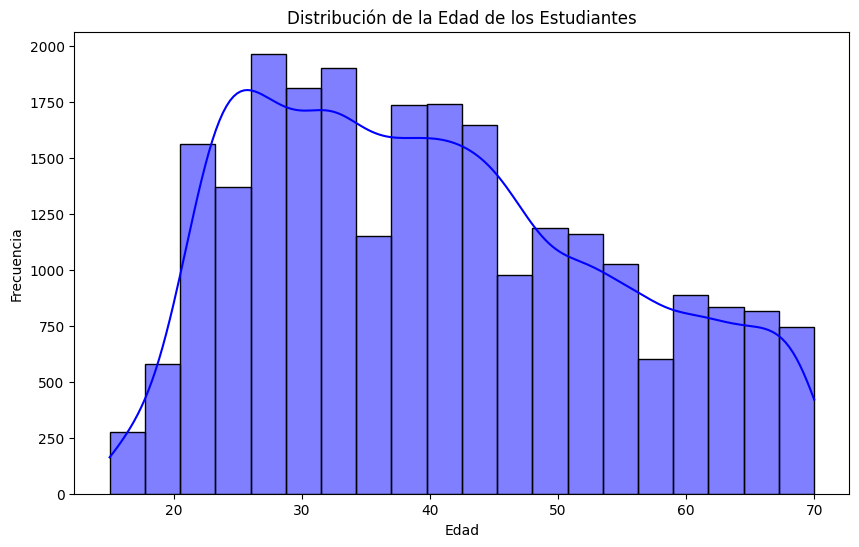

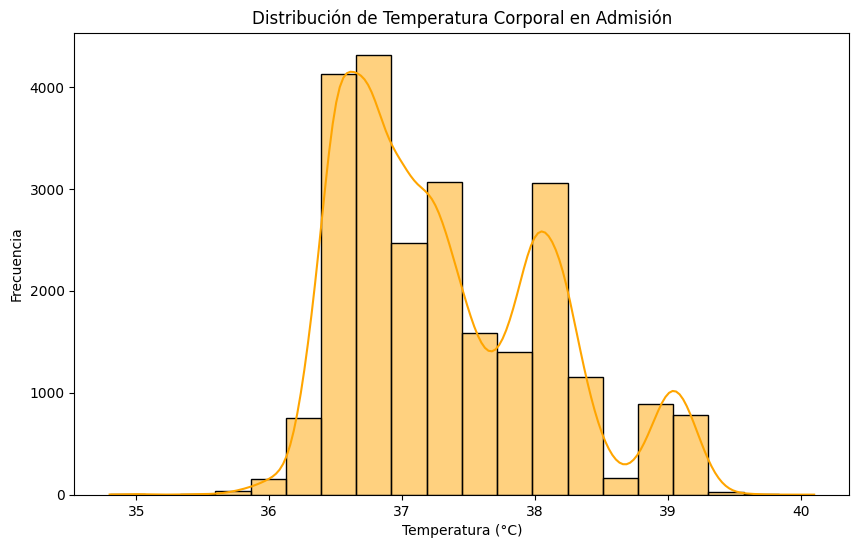

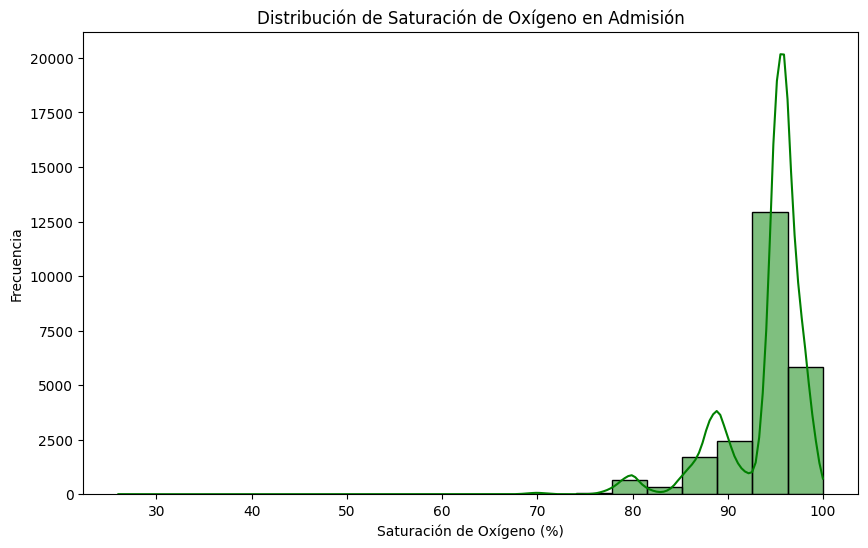

C:\Users\daV\AppData\Local\Temp\ipykernel_4792\432255725.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


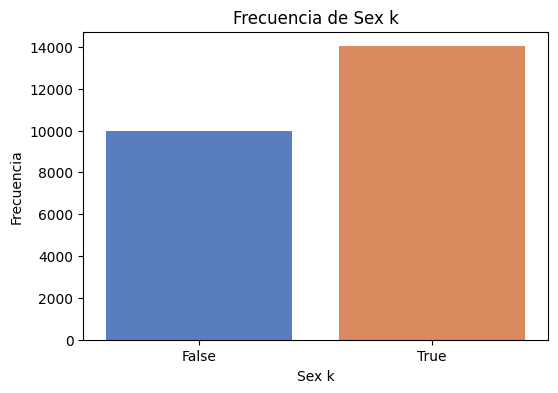

C:\Users\daV\AppData\Local\Temp\ipykernel_4792\432255725.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


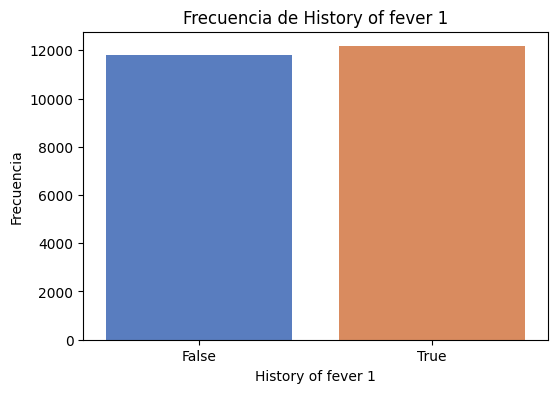

C:\Users\daV\AppData\Local\Temp\ipykernel_4792\432255725.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


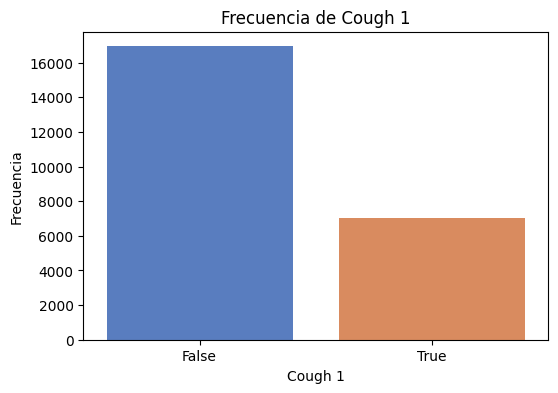

C:\Users\daV\AppData\Local\Temp\ipykernel_4792\432255725.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


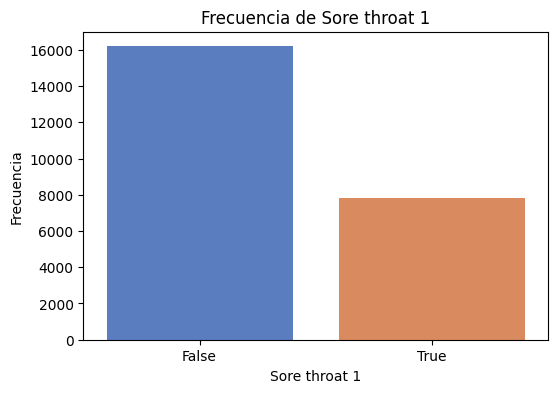

C:\Users\daV\AppData\Local\Temp\ipykernel_4792\432255725.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


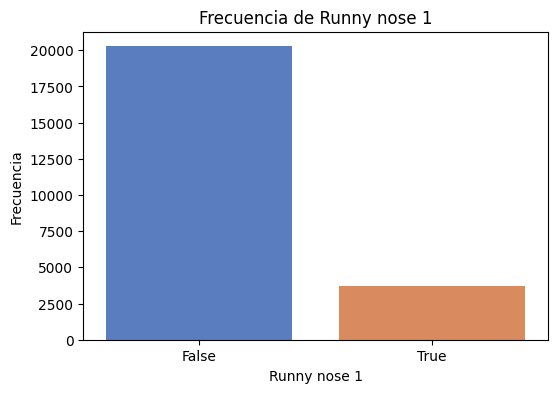

C:\Users\daV\AppData\Local\Temp\ipykernel_4792\432255725.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


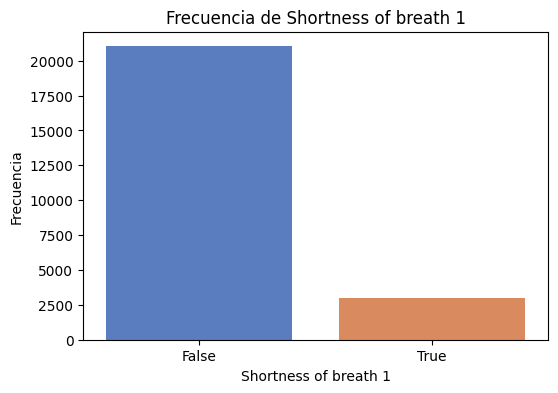

C:\Users\daV\AppData\Local\Temp\ipykernel_4792\432255725.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


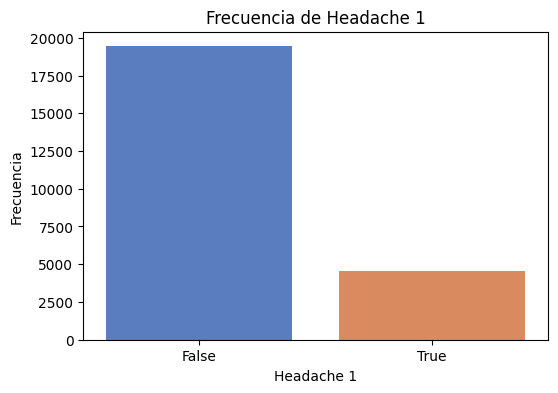

C:\Users\daV\AppData\Local\Temp\ipykernel_4792\432255725.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


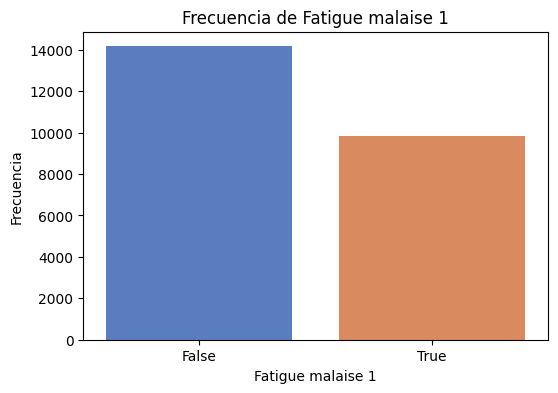

C:\Users\daV\AppData\Local\Temp\ipykernel_4792\432255725.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


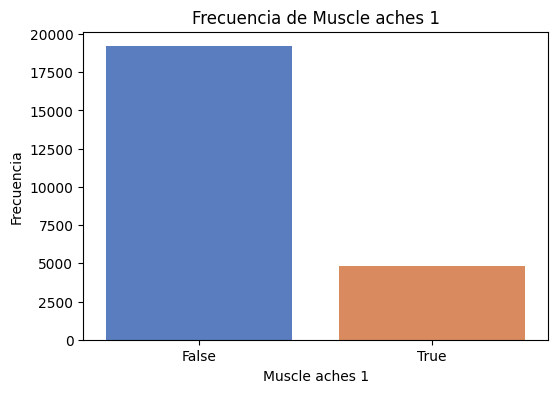

C:\Users\daV\AppData\Local\Temp\ipykernel_4792\432255725.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


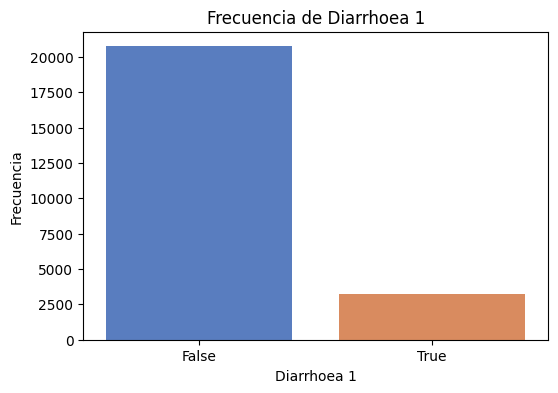

C:\Users\daV\AppData\Local\Temp\ipykernel_4792\432255725.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


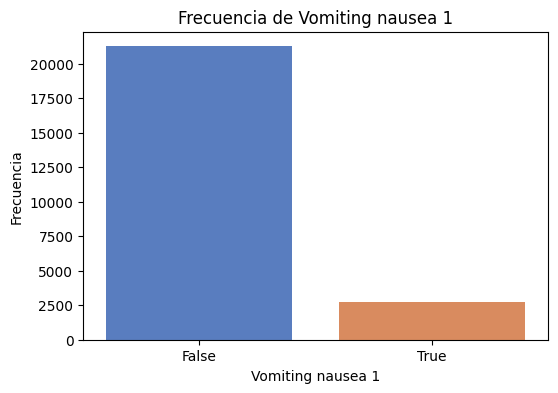

C:\Users\daV\AppData\Local\Temp\ipykernel_4792\432255725.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


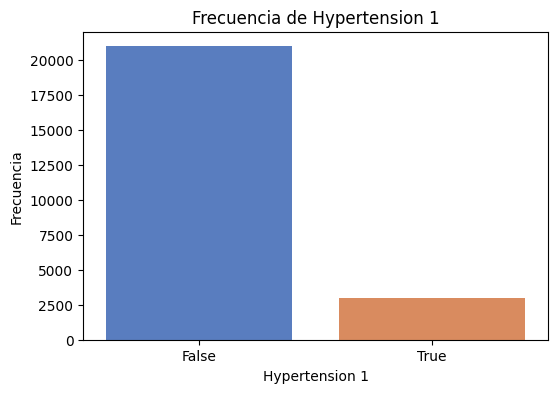

C:\Users\daV\AppData\Local\Temp\ipykernel_4792\432255725.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


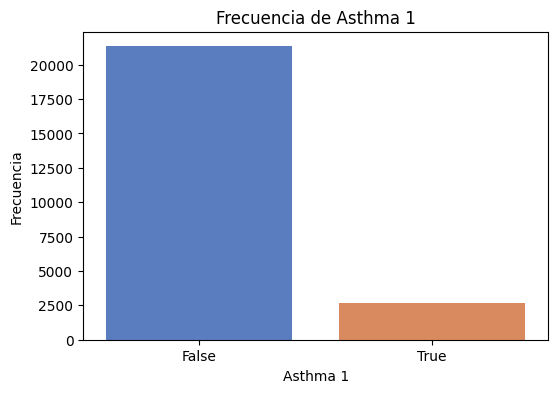

C:\Users\daV\AppData\Local\Temp\ipykernel_4792\432255725.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


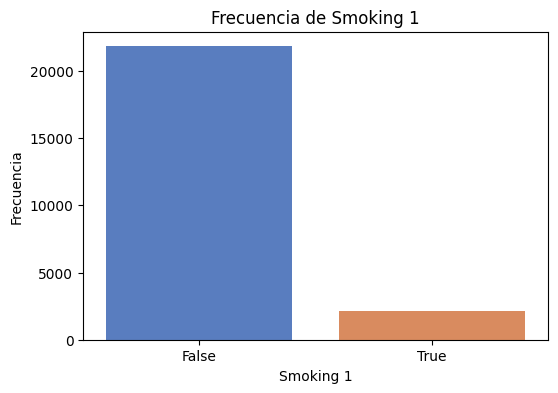

C:\Users\daV\AppData\Local\Temp\ipykernel_4792\432255725.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=combined_data, palette='muted')


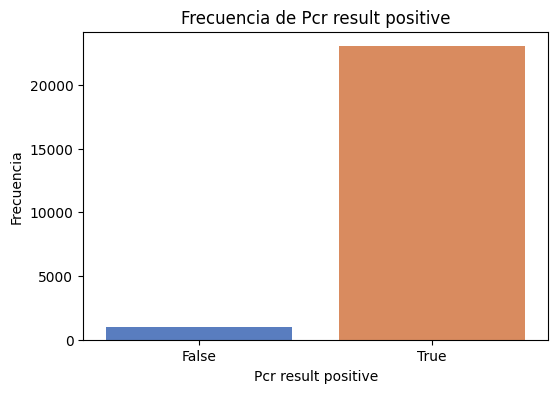

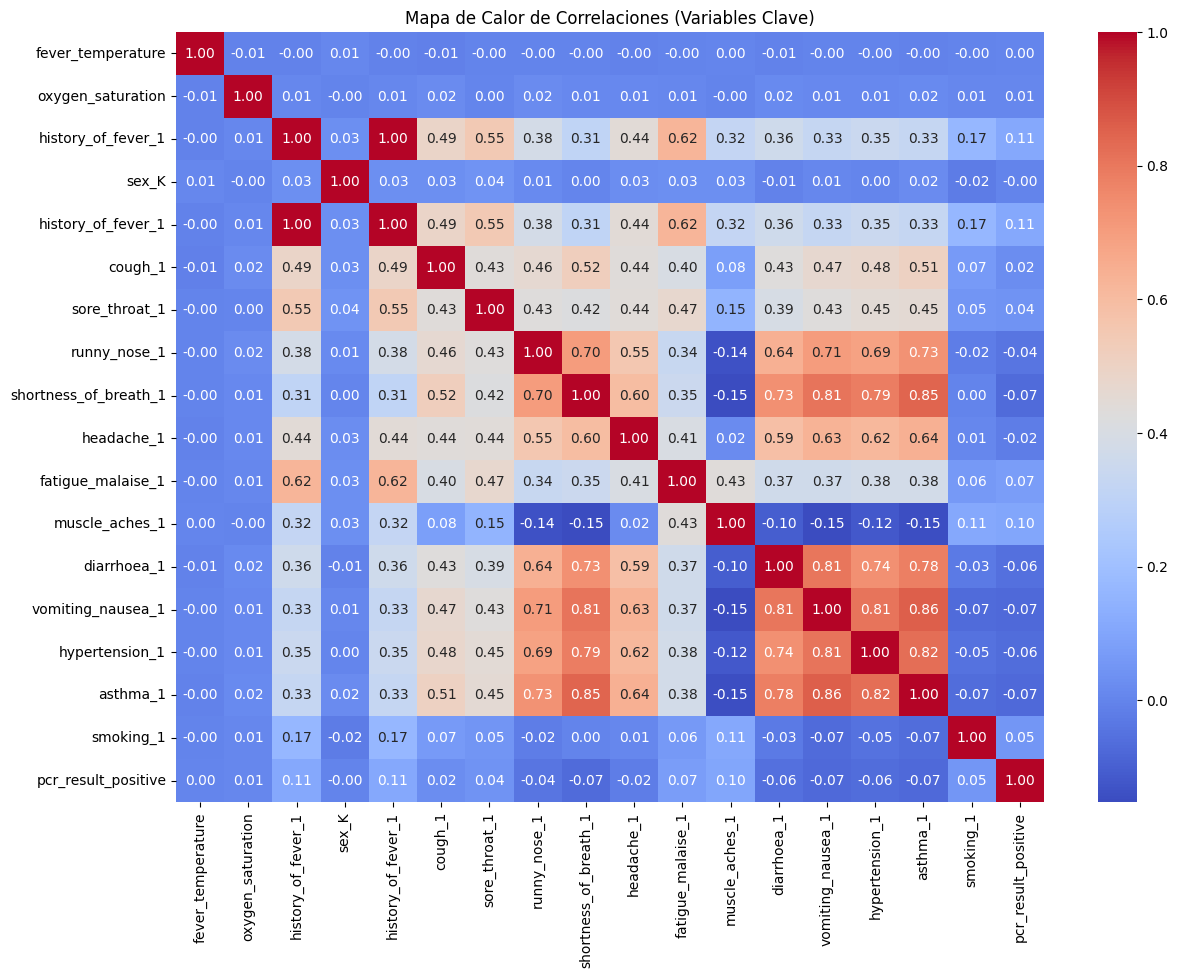

In [11]:
# Estadísticas descriptivas generales
print("Estadísticas descriptivas del dataset:")
print(combined_data.describe())

# Distribución de la Edad
plt.figure(figsize=(10, 6))
sns.histplot(combined_data['age'], bins=20, kde=True, color='blue')
plt.title('Distribución de la Edad de los Estudiantes')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

# Distribución de la Temperatura Corporal
if 'fever_temperature' in combined_data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(combined_data['fever_temperature'], bins=20, kde=True, color='orange')
    plt.title('Distribución de Temperatura Corporal en Admisión')
    plt.xlabel('Temperatura (°C)')
    plt.ylabel('Frecuencia')
    plt.show()

# Distribución de la Saturación de Oxígeno
if 'oxygen_saturation' in combined_data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(combined_data['oxygen_saturation'], bins=20, kde=True, color='green')
    plt.title('Distribución de Saturación de Oxígeno en Admisión')
    plt.xlabel('Saturación de Oxígeno (%)')
    plt.ylabel('Frecuencia')
    plt.show()

# Relación entre PCR Result y otras variables
if 'pcr_result_1' in combined_data.columns:
    plt.figure(figsize=(6, 6))
    sns.countplot(x='pcr_result_1', data=combined_data, palette='viridis')
    plt.title('Distribución de Resultados de PCR')
    plt.xlabel('Resultado de PCR (1 = Positivo)')
    plt.ylabel('Frecuencia')
    plt.show()

# Análisis de comorbilidades (solo variables con más del 5% de incidencia)
binary_cols = [col for col in combined_data.columns if combined_data[col].dropna().isin([0, 1]).all()]
comorbidity_threshold = 0.05  # Filtrar variables con al menos 5% de incidencia
relevant_binary_cols = [
    col for col in binary_cols
    if combined_data[col].mean() > comorbidity_threshold
]
for col in relevant_binary_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=combined_data, palette='muted')
    plt.title(f'Frecuencia de {col.replace("_", " ").capitalize()}')
    plt.xlabel(col.replace("_", " ").capitalize())
    plt.ylabel('Frecuencia')
    plt.show()

# Heatmap de correlación (centrado en variables relevantes)
plt.figure(figsize=(14, 10))
# Seleccionar las columnas numéricas con más relevancia (e.g., síntomas y resultados)
correlation_columns = ['fever_temperature', 'oxygen_saturation', 'history_of_fever_1'] + relevant_binary_cols
correlation_matrix = combined_data[correlation_columns].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Mapa de Calor de Correlaciones (Variables Clave)')
plt.show()


#### Preprocessing Explanation

- **Imputing Null Values**: We use the median and the mode to handle missing values. This helps avoiding biases and ensuring data consistency.
- **Encoding Categorical Variables**: One-hot encoding is applied to  `sex` & `PCR_result` to convert those categories into an adecuate format for the model.
- **Inconsistent Value Deletion**: We handle anomalies in `oxygen_saturation` to help keep the model's accuracy.


#### Model Selection and Reasoning

We select `Random Forest`:

As we want to predict those students who are at great risk of suffering medical complications from a COVID-19 infection, we will use a Random Forest classification model. The main reasons for this are:

    - Able to handle heterogeneous data: handles numerical and categorical variables.
    - Robust against overfitting: its capacity to use tree ensembles to control overfitting.
    - Interpretability: able to provide importance metrics of each variable, which helps understand which are the most relevant factors that determine risk.

#### Data Preparation

In [12]:
y = combined_data["pcr_result_positive"]  
X = combined_data.drop(columns=["pcr_result_positive"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.shape, y.shape

((23991, 48), (23991,))

#### Initial Training

In [13]:
print("Class distribution in y_train:", y_train.value_counts())  #Critical!!

Class distribution in y_train: pcr_result_positive
True     18408
False      784
Name: count, dtype: int64


 #### Hiperparameter optimization using GridSearchCV

In [33]:
# RANDOM FOREST
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'bootstrap': [True, False],
    'class_weight': ['balanced']  # bc we have much more positive then negative cases
}

# Búsqueda con GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='f1', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo obtenido
rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [17]:
# CATBOOST
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    auto_class_weights='Balanced',  # Handles imbalance
    random_state=42,
    verbose=100
)

catboost_model.fit(X_train, y_train)


0:	learn: 0.6402994	total: 187ms	remaining: 1m 33s
100:	learn: 0.4612642	total: 1.87s	remaining: 7.38s
200:	learn: 0.4031851	total: 3.45s	remaining: 5.14s
300:	learn: 0.3633393	total: 5.04s	remaining: 3.33s
400:	learn: 0.3305665	total: 6.78s	remaining: 1.67s
499:	learn: 0.3062960	total: 8.54s	remaining: 0us


In [24]:
from lightgbm import LGBMClassifier

param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [5, -1],  # -1 for no limit
    'class_weight': ['balanced'],  # Handles imbalance
    'min_data_in_leaf': [20, 50]
}

grid_search = GridSearchCV(estimator=LGBMClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='f1', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

lgbm_model = grid_search.best_estimator_


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 18408, number of negative: 784
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 309
[LightGBM] [Info] Number of data points in the train set: 19192, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [28]:
from xgboost import XGBClassifier

param_grid = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 7],
    'scale_pos_weight': [1, 10, 20]  # Adjust for imbalance
}

grid_search = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                           param_grid=param_grid,
                           scoring='f1', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

xgb_model = grid_search.best_estimator_


Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\daV\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:40:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#### Evaluación del Modelo Optimizado

In [34]:
models = [(xgb_model, "xgb_model"), (lgbm_model, "lgbm_model"), (catboost_model, "catboost_model"), (rf_model, "rf_model")]

In [40]:
model.predict_proba(X_test)

array([[0.05104578, 0.9489542 ],
       [0.05177993, 0.9482201 ],
       [0.08759743, 0.9124026 ],
       ...,
       [0.05104578, 0.9489542 ],
       [0.05177993, 0.9482201 ],
       [0.05104578, 0.9489542 ]], dtype=float32)

xgb_model
Precisión (Accuracy): 0.9606167951656596
Precisión (Precision): 0.9227846271543427
Sensibilidad (Recall): 0.9606167951656596
F1-Score: 0.941320740931808


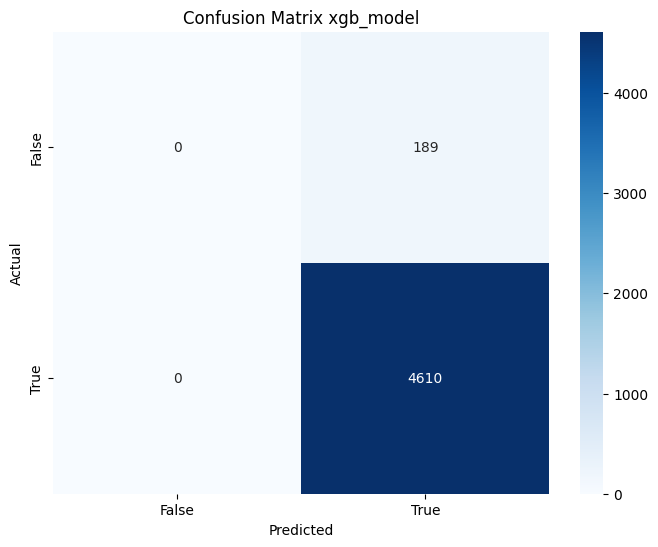

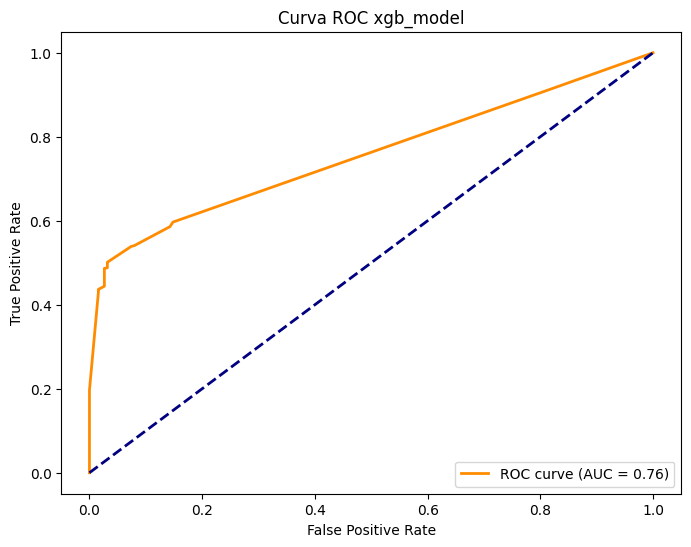

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
lgbm_model
Precisión (Accuracy): 0.7607834965617837
Precisión (Precision): 0.9363600342518519
Sensibilidad (Recall): 0.7607834965617837
F1-Score: 0.8325096049202544


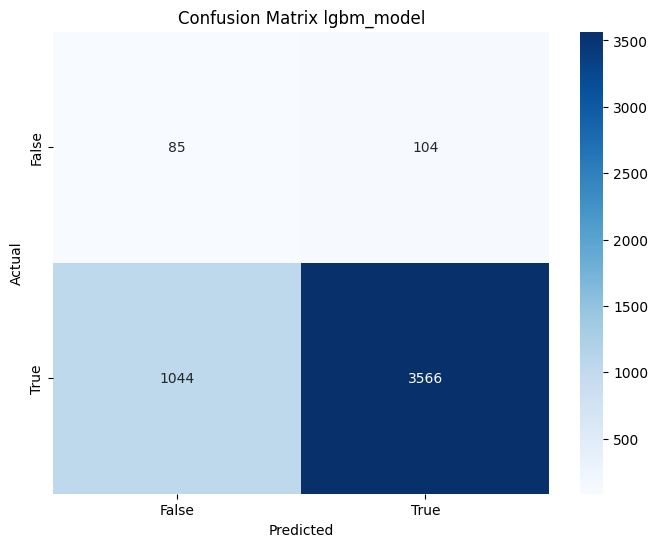

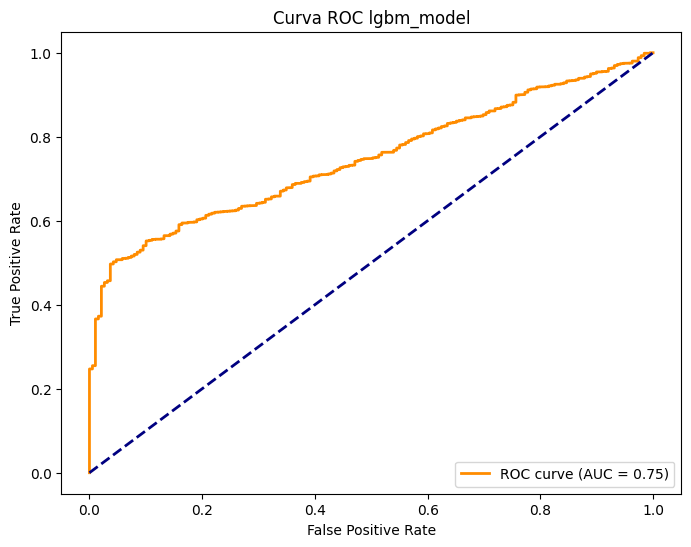

catboost_model
Precisión (Accuracy): 0.7349447801625338
Precisión (Precision): 0.9353969613350993
Sensibilidad (Recall): 0.7349447801625338
F1-Score: 0.815454476802365


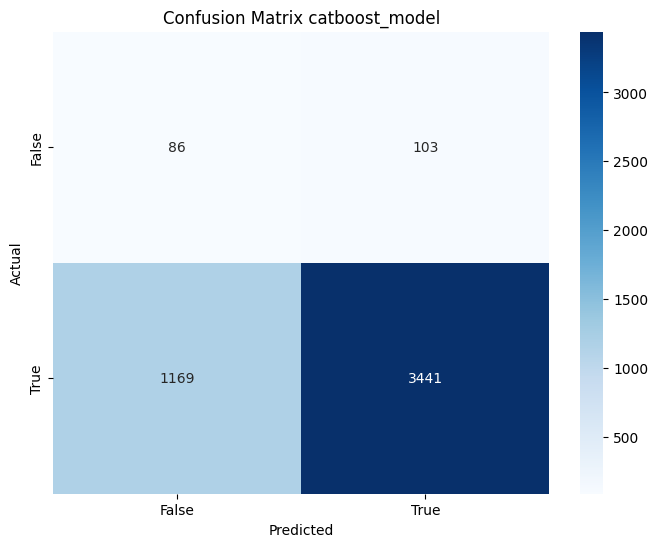

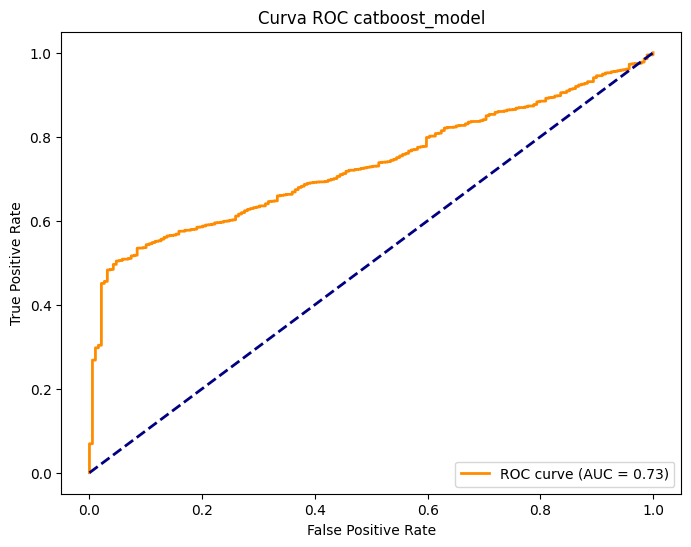

rf_model
Precisión (Accuracy): 0.6359658262137945
Precisión (Precision): 0.950387041591297
Sensibilidad (Recall): 0.6359658262137945
F1-Score: 0.7441921161502283


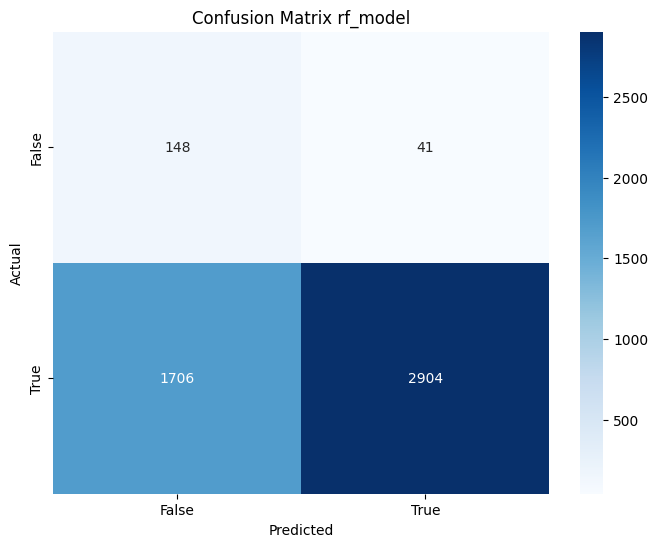

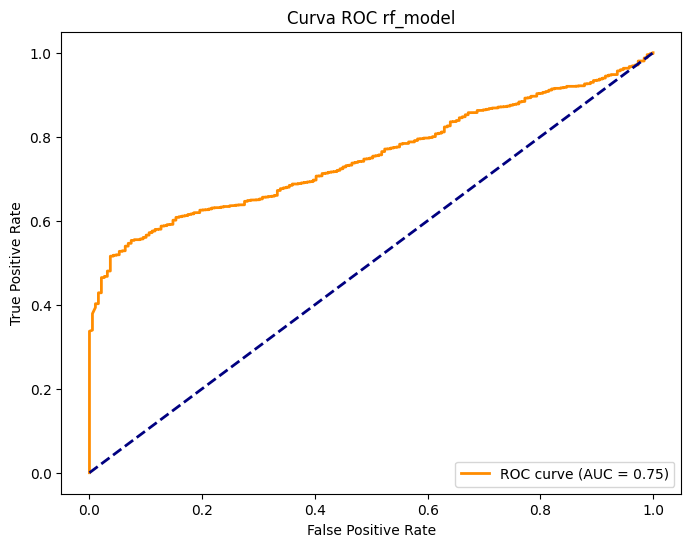

In [42]:
def test_model(model, model_name):
    # Predicciones y probabilidades
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # for second class
    
    print(model_name.upper())
    print("Precisión (Accuracy):", accuracy_score(y_test, y_pred))
    print("Precisión (Precision):", precision_score(y_test, y_pred, average='weighted', zero_division=0))  # Changed to weighted
    print("Sensibilidad (Recall):", recall_score(y_test, y_pred, average='weighted'))  # Specify average for recall
    print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))  # Specify average for F1 score
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix ' + model_name)
    plt.show()
    
    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC ' + model_name)
    plt.legend(loc='lower right')
    plt.show()

for model, model_name in models:
    test_model(model, model_name)

**Metrics Evaluation and Relatedness with the KPIs**

- **Precision**: Ensures that most of the students classified as high risk are really high-risk, minimizing false positives.
- **Recall**: Evaluates if the model is able to identify all of the high-risk students, which is key for our preventive measures.
- **F1-Score**: Balnces precision and recall, essential in situations such as the one described in our project, where both are equally important.
